<a href="https://colab.research.google.com/github/shahab-f/EAI6010-Applications_of_Artificial_Intelligence-Winter_2023/blob/Neural-style-transfer-using-TensorFlow-Hub/EAI6010_ShahabaddinFeghahati_Week2_Winter_2023_rev_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Artistic Style Transfer with Tensorflow and Python

## Introduction

This study demonstrates the effective utilization of TensorFlow and TensorFlow Hub to stylize images with the help of a pre-trained model. The code imports sample images from the internet and applies a specific style to them using the pre-trained model. Additionally, users have the option to upload their own images and use the same stylization technique.

## Body

##*Copyright Notice and License Information for TensorFlow Hub*

Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved. This work is licensed under the Apache License, Version 2.0. You may only use this file in compliance with the License. To obtain a copy of the License, please visit http://www.apache.org/licenses/LICENSE-2.0. The software distributed under this License is provided on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. Refer to the License for specific language regarding permissions and limitations.

## *Fast Style Transfer for Arbitrary Styles (Attributions for the Model Code and Publication Used in the Work.)*

This work is based on the model code found in [magenta] (https://github.com/tensorflow/magenta/tree/master/magenta/models/arbitrary_image_stylization) and the publication titled [Exploring the structure of a real-time, arbitrary neural artistic stylization network] (https://arxiv.org/abs/1705.06830) (Ghiasi et al., 2017).

In [ ]:
# @title Setup

# Let's start with importing TF-2 and all relevant dependencies

import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)
print("TF-Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


TF Version:  2.11.0
TF-Hub version:  0.12.0
Eager mode enabled:  True
GPU available:  True


In [ ]:
# @title Define image loading and visualization functions  { display-mode: "form" }

def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image

@functools.lru_cache(maxsize=None)
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
  # Cache image file locally.
  image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = plt.imread(image_path).astype(np.float32)[np.newaxis, ...]
  if img.max() > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img

def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w  * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()

def load_local_image(image_bytes, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
   # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = image_bytes
  if img.max() > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img


In [ ]:
# @title Import TF-Hub module
# Load TF-Hub module.

hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

To start off, it's recommended that you give the original files sourced from Tensorflow a try first.

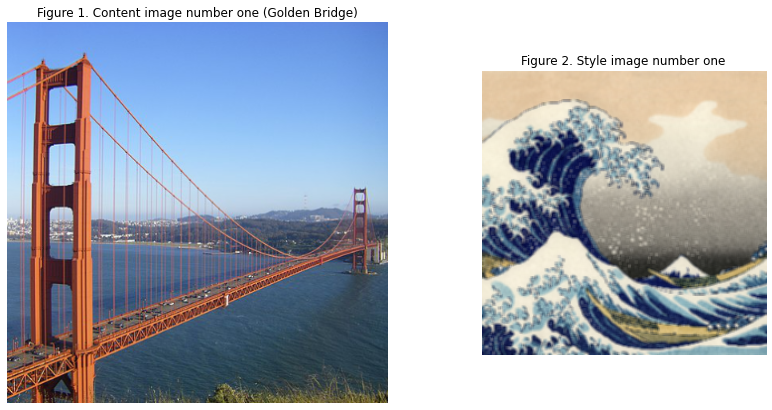

In [ ]:
# @title Figure 1. Example images used for style transfer { display-mode: "form" }

content_image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Golden_Gate_Bridge_from_Battery_Spencer.jpg/640px-Golden_Gate_Bridge_from_Battery_Spencer.jpg'  # @param {type:"string"}
style_image_url = 'https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg'  # @param {type:"string"}
output_image_size = 384  # @param {type:"integer"}

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the 
# recommended image size for the style image (though, other sizes work as 
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
show_n([content_image, style_image], ['Figure 1. Content image number one (Golden Bridge)', 'Figure 2. Style image number one'])



## Demonstrate image stylization

The signature of this hub module for image stylization is:
```
outputs = hub_module(content_image, style_image)
stylized_image = outputs[0]
```
Where `content_image`, `style_image`, and `stylized_image` are expected to be 4-D Tensors with shapes `[batch_size, image_height, image_width, 3]`.

In the current example we provide only single images and therefore the batch dimension is 1, but one can use the same module to process more images at the same time. The input and output values of the images should be in the range [0, 1]. The shapes of content and style image don't have to match. Output image shape is the same as the content image shape.

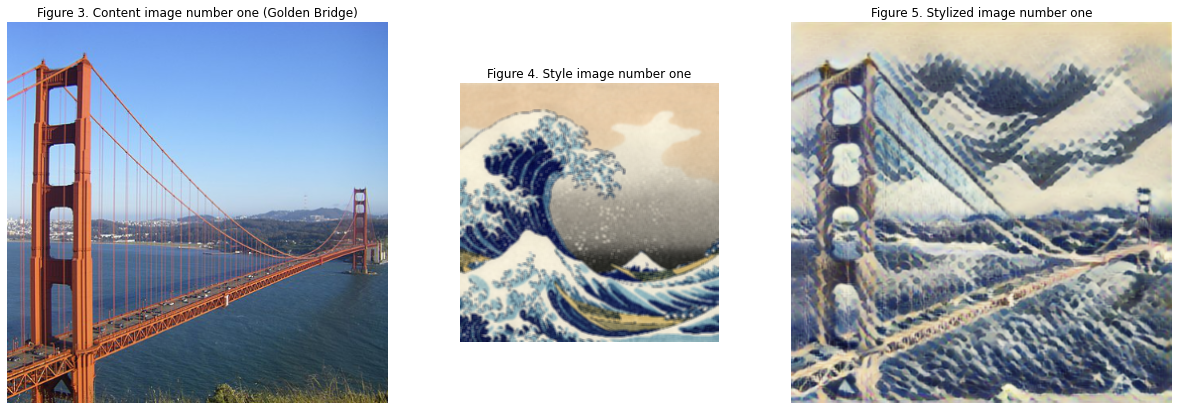

In [ ]:
# @title Calculate and Display

# Stylize content image with given style image.
# This is pretty fast within a few milliseconds on a GPU.
outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

# Visualize input images and the generated stylized image.
show_n([content_image, style_image, stylized_image],
       titles=['Figure 3. Content image number one (Golden Bridge)',
               'Figure 4. Style image number one',
               'Figure 5. Stylized image number one'])

Let's get as well some images to play with.

Browse to the style file  to be uploaded


Saving NortheasternLogo_256x256.jpg to NortheasternLogo_256x256 (8).jpg
User uploaded file NortheasternLogo_256x256.jpg with length 24546 fbytes
Browse to the content file to be uploaded


Saving pic.jpg to pic (9).jpg
User uploaded content file pic.jpg with length 48736 fbytes


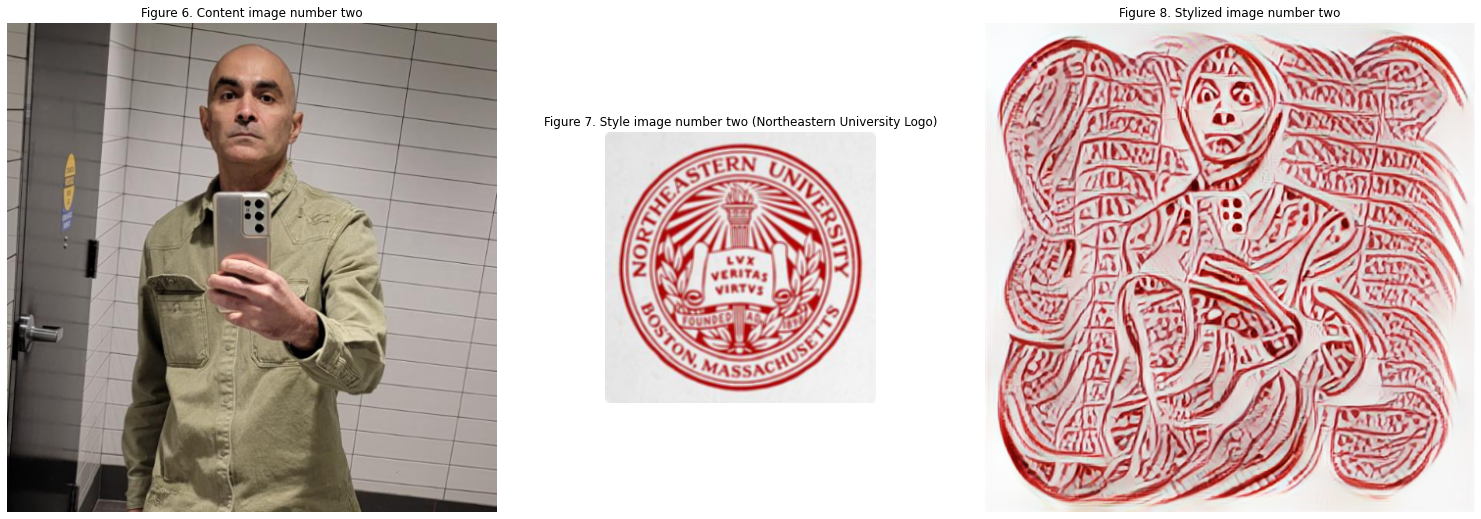

In [ ]:
from google.colab import files
# load style image from the local filesystem
print("Browse to the style file  to be uploaded") 
style_uploaded = files.upload()
for fn in style_uploaded.keys():
  print("User uploaded file {name} with length {length} fbytes".format(name=fn, 
                                                      length=len(style_uploaded[fn])))
style_img = plt.imread(fn).astype(np.float32)[np.newaxis, ...]

# load content image from the local filesystem
print("Browse to the content file to be uploaded") 
content_uploaded = files.upload()
for fn in content_uploaded.keys():
  print("User uploaded content file {name} with length {length} fbytes".format(name=fn,
                                                      length=len(content_uploaded[fn])))
content_img = plt.imread(fn).astype(np.float32)[np.newaxis, ...]

# @title Load example images  { display-mode: "form" }
output_image_size = 500  # @param {type:"integer"}

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the 
# recommended image size for the style image (though, other sizes work as 
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_local_image(content_img, content_img_size) #load_image(content_image_url, content_img_size)
style_image = load_local_image(style_img, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
#show_n([content_image, style_image], ['Content image', 'Style image'])

# Stylize content image with given style image.
# This is pretty fast within a few milliseconds on a GPU.
outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

# Visualize input images and the generated stylized image.
show_n([content_image, style_image, stylized_image], titles=['Figure 6. Content image number two', 'Figure 7. Style image number two (Northeastern University Logo)', 'Figure 8. Stylized image number two'])

Browse to the style file  to be uploaded


Saving Van Gogh.jpg to Van Gogh (3).jpg
User uploaded file Van Gogh.jpg with length 853135 fbytes
Browse to the content file to be uploaded


Saving pic.jpg to pic (10).jpg
User uploaded content file pic.jpg with length 48736 fbytes


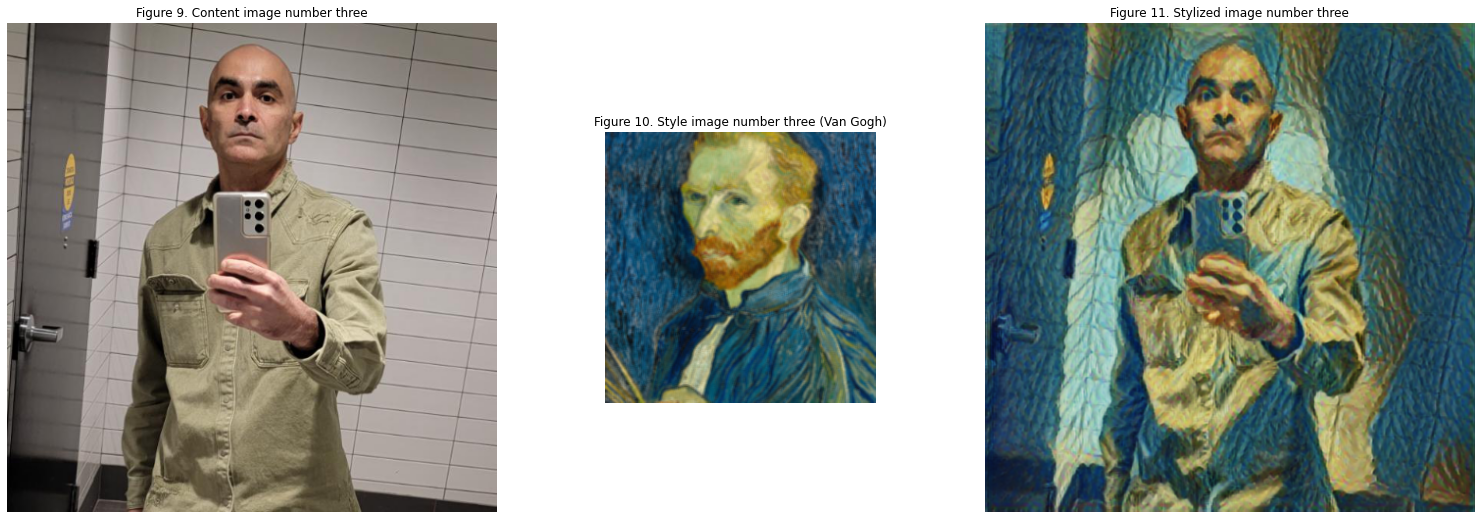

In [ ]:
from google.colab import files
# load style image from the local filesystem
print("Browse to the style file  to be uploaded") 
style_uploaded = files.upload()
for fn in style_uploaded.keys():
  print("User uploaded file {name} with length {length} fbytes".format(name=fn, 
                                                      length=len(style_uploaded[fn])))
style_img = plt.imread(fn).astype(np.float32)[np.newaxis, ...]

# load content image from the local filesystem
print("Browse to the content file to be uploaded") 
content_uploaded = files.upload()
for fn in content_uploaded.keys():
  print("User uploaded content file {name} with length {length} fbytes".format(name=fn,
                                                      length=len(content_uploaded[fn])))
content_img = plt.imread(fn).astype(np.float32)[np.newaxis, ...]

# @title Load example images  { display-mode: "form" }
output_image_size = 500  # @param {type:"integer"}

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the 
# recommended image size for the style image (though, other sizes work as 
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_local_image(content_img, content_img_size) #load_image(content_image_url, content_img_size)
style_image = load_local_image(style_img, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
#show_n([content_image, style_image], ['Content image', 'Style image'])

# Stylize content image with given style image.
# This is pretty fast within a few milliseconds on a GPU.
outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

# Visualize input images and the generated stylized image.
show_n([content_image, style_image, stylized_image], titles=['Figure 9. Content image number three', 'Figure 10. Style image number three (Van Gogh)', 'Figure 11. Stylized image number three'])

## Analysis

The above code implements neural style transfer using TensorFlow and TensorFlow Hub, using a pre-trained model from TensorFlow Hub for arbitrary style transfer. The first step of the code involves importing necessary modules like numpy, TensorFlow, TensorFlow Hub, and Matplotlib. It then defines a function to load an image from a URL, preprocess it, and return it in a format that can be used by the model.

Next, the code loads two example images (the Golden Gate Bridge and The Great Wave off Kanagawa) from URLs, resizes them to appropriate sizes, and applies neural style transfer to generate a stylized image.

After generating the first stylized image, the code provides the user with the option to upload their own style and content images from their local filesystem. The uploaded images are then loaded, preprocessed, and stylized in the same way as the example images. The final output includes three images: the content image, the style image, and the stylized image generated by the model.


## Conclusion

In conclusion, this code provides a simple and efficient way to stylize images using pre-trained models. The code can be easily adapted to work with other pre-trained models and can be extended to create more complex image processing pipelines. This code serves as a useful starting point for anyone interested in image stylization and related applications.

## References


*API documentation &nbsp;: &nbsp; tensorflow V2.11.0.* TensorFlow. (n.d.). Retrieved February 27, 2023, from https://www.tensorflow.org/api_docs 

Ghiasi, G., Lee, H., Kudlur, M., Dumoulin, V., & Shlens, J. (2017). *Exploring the structure of a real-time, arbitrary neural artistic stylization network.* https://doi.org/10.48550/arxiv.1705.06830

